# CS166 LBA 

## Creating the Model 

In [519]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as sts

### Creating Classes for Each of the segments in the model 

In [749]:
class Car: 
    """
    Creating cars as an object helps in gathering data 
    for car-specific metrics. It was also used for deciding turns in intersections 
    """
    def __init__(self, speed, idx = 0):
        # Might need to add: random slow
        self.speed = speed 
        self.position = idx
        self.time = 0 
        
    def turn(self):
        # Decide if car is going to turn 
        if np.random.uniform() <= 0.5:
            return True 
        else: 
            return False 
        
    def __repr__(self):
        return str(self.speed)
    

class Lane: 
    """
    Each lane object is assigned to different segments in the model. 
    This way, the lanes would continously operate despite traffic lights. 
    
    """
    
    # All 0 unless specified
    def __init__(self, road_length = 0, car_spawn_prob = 0, max_speed = 0, 
                 prob_slow = 0, gen_car = True, end_road = False):
        self.road_length = road_length 
        self.car_spawn_prob = car_spawn_prob
        self.max_speed = max_speed
        self.prob_slow = prob_slow 
        self.generate_car_isTrue = gen_car 
        self.end_road = end_road 
        
        self.state = np.full(self.road_length, '.')
        self.state = list(self.state)
        
        # Metrics 
        self.car_times = []
        self.lane_densities = [] 
        
        # Create one starting car 
        if gen_car == True:
            self.add_car(Car(0), 0)
        
    def state_reset(self):
        self.state = np.full(self.road_length, '.')
        self.state = list(self.state)
        
    def add_car(self, car, idx):
        self.state[idx] = car
        car.position = idx
        
    def generate_car(self):
        if np.random.uniform() <= self.car_spawn_prob:
            self.add_car(Car(0), 0)
        
    def switch_to_int(self):
        """
        Switch state to iteratable list 
        This is used for graphing 
        """
        
        int_list = []
        for i in self.state:
            if i == '.':
                int_list.append(-1)
            else:
                int_list.append(i.speed)
                
        return int_list 
        
    def update(self):
        """
        Updates the movements in the line segment. 
        It first checks if the segment is an outflow lane 
        and therefore removes the cars at the end of the lane. 
        Then, it continuously updates acceleration, deceleration and 
        random slows in the system. 
        
        If the lane is an inflow lane, it will randomly generate cars 
        at the start of the lane based on the probability it was assigned. 
        
        """
        
        ### Pre-movement checks
        # Check if it is an outflow lane 
        if self.end_road == True:
            if self.state[-1] != '.':
                self.car_times.append(self.state[-1].time)
            self.state[-1] = '.'

        
        ###
        # Update Car Speeds 
        
        for i in range(self.road_length):
            if self.state[i] != '.':
                distance = 1 
                
                # check if car is at the end of the road 
                # if yes, then we don't get distance 
                if self.state.index(self.state[i]) != self.road_length - 1:
                
                    while (self.state[i + distance] == '.') and (i + distance != self.road_length - 1):
                        distance += 1 

                    # push car to the end of the road if there is no car there 
                    if (i + distance == self.road_length - 1) and (self.state[-1] == '.'):
                        distance += 1
                
                
                # Acceleration 
                if self.state[i].speed < self.max_speed:
                    self.state[i].speed += 1 

                # Deceleration 
                if self.state[i].speed >= distance:
                    self.state[i].speed = distance - 1 
                    

                #Randomization 
                if (
                    (self.state[i].speed > 0) and 
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i].speed -= 1 
                
        ###
        # Move Cars based on speed 

        new_state = np.full(self.road_length, '.')
        new_state = list(new_state)
        
        for i in range(self.road_length):
            car = self.state[i]
            
            if car != '.':
                new_state[(i + car.speed)] = car 
                car.position = i + car.speed 
                
        self.state = new_state
        
        # Check if it is an inflow lane 
        if self.generate_car_isTrue:
            # Check first if first cell is empty
            if self.state[0] == '.':
                self.generate_car()
        
        # Update time of car in the system 
        for car in self.state:
            if car != '.':
                car.time += 1 
                
        # Update average traffic flow 
        car_count = 0 
        for cell in self.state:
            if cell != '.':
                car_count += 1 
                
        self.lane_densities.append(car_count/self.road_length)
            
        
class ConnectingLanes:
    """
    Creates a collection of lanes that are connected between intersections.
    Allows cars to cross intersections
    
    """
    
    def __init__(self, lanes, TLisGreen = True ):
        
        self.lanes = lanes 
        self.TLisGreen = TLisGreen 

In [839]:
class SF_Traffic_Sim:
    
    def __init__(self):
        
        # Initialize lanes 
        
        #def __init__(self, road_length = 0, car_spawn_prob = 0, max_speed = 0, 
        # prob_slow = 0, gen_car = True, end_road = False, TL = 'GREEN'):
            # road_length 
            # car_spawn_prob
            # max_speed 
            # prob_slow 
            # gen_car
            # end_road
            # TL 
        
        self.jonesA = Lane(road_length = 6, car_spawn_prob = 0.3,
                     max_speed = 3, prob_slow = 0.1, gen_car = True) 

        self.jonesB = Lane(road_length = 8, max_speed = 2, 
                      prob_slow = 0.2, gen_car = False, end_road = True) 
        
        self.pineC = Lane(road_length = 4, max_speed = 2, 
                      prob_slow = 0.3, gen_car = False, end_road = True)
        
        self.pineB = Lane(road_length = 11, max_speed = 3,
                         prob_slow = 0.4, gen_car = False, end_road = False)
        
        self.pineA = Lane(road_length = 5, max_speed = 3, car_spawn_prob = 0.9, 
                         prob_slow = 0.1, gen_car = True, end_road = False)
        
        self.taylorA = Lane(road_length = 8, max_speed = 3, car_spawn_prob = 0.25,
                           prob_slow = 0.2, gen_car = True, end_road = False)
        
        self.taylorB = Lane(road_length = 6, max_speed = 3, 
                           prob_slow = 0.2, gen_car = False, end_road = True )
        
        # All Lanes
        self.all_lanes = [self.jonesA, self.jonesB, self.pineB, self.pineC, self.pineA, 
                         self.taylorA, self.taylorB]
    
        ### Set-up traffic lights and connecting lanes ###  
        # We have 4 lanes that are dependent on the traffic light 
        
        # First Connection (JonesA -> (JonesB & PineC))
        # IMPORTANT: Format(initial lane, same street, turning street)
        self.first_connection = ConnectingLanes(lanes = [self.jonesA, self.jonesB, self.pineC],
                                               TLisGreen = True)
        
        # Second Connection (PineB -> (PineC & JonesB))
        self.second_connection = ConnectingLanes(lanes = [self.pineB, self.pineC, self.jonesB],
                                                 TLisGreen = False) 
        
        # Third Connection (TaylorA -> (TaylorB & PineB))
        self.third_connection = ConnectingLanes(lanes = [self.taylorA, self.taylorB, self.pineB],
                                               TLisGreen = True)
        
        # Fourth Connection (PineA -> (PineB & TaylorB))
        self.fourth_connection = ConnectingLanes(lanes = [self.pineA, self.pineB, self.taylorB],
                                                TLisGreen = False)
        
    def transfer_lanes(self, connection):
        """
        Checks at the cells beside intersection point and makes transfers 
        based on car's direction 
        """
        # Check if end of road is empty 
        
        # Seperate streets in each connection 
        initial_street = connection[0]
        same_street = connection[1] 
        turning_street = connection[2]
        
        if initial_street.state[-1] != '.':
            
            # Check for car's direction 
            pivot_car = initial_street.state[-1]
            will_turn = pivot_car.turn()
            pivot_car.speed = 0
            
            # Car is going straight
            if (will_turn == False and same_street.state[0] == '.'):
                initial_street.state[-1] = '.'
                same_street.state[0] = pivot_car 
            
            # Car will make a turn 
            elif (will_turn == True and turning_street.state[0] =='.'):
                initial_street.state[-1] = '.'
                turning_street.state[0] = pivot_car 

    def TL_change_A(self):
        """
        Synchronizes Traffic light changes for intersection A
        """
        
        self.first_connection.TLisGreen = not self.first_connection.TLisGreen
        self.second_connection.TLisGreen = not self.second_connection.TLisGreen
        
    def TL_change_B(self):
        """
        Synchronizes Traffic light changes for intersection A
        """
        self.third_connection.TLisGreen = not self.third_connection.TLisGreen
        self.fourth_connection.TLisGreen = not self.fourth_connection.TLisGreen
    
    def update(self):
        """
        Simulates the movement amongst all lanes. It first checks for cars 
        by the intersection 
        """
        
        if self.first_connection.TLisGreen == True:
            self.transfer_lanes(self.first_connection.lanes)
        
        if self.second_connection.TLisGreen == True:
            self.transfer_lanes(self.second_connection.lanes)
            
        if self.third_connection.TLisGreen == True: 
            self.transfer_lanes(self.third_connection.lanes)
            
        if self.fourth_connection.TLisGreen == True:
            self.transfer_lanes(self.fourth_connection.lanes)
        
        for lane in self.all_lanes:
            lane.update()
            
    def draw(self):
        grid = np.full([15,22], 3)

        # Pine A 
        grid[6, 17:22] = (self.pineA.switch_to_int())[::-1]
        # Pine B
        grid[6, 5:16] = (self.pineB.switch_to_int())[::-1]
        #Pine C 
        grid[6, 0:4] = (self.pineC.switch_to_int())[::-1]
        
        # Taylor A 
        grid[7:15, 16] = (self.taylorA.switch_to_int())[::-1]
        # Taylor B
        grid[0:6, 16] = (self.taylorB.switch_to_int())[::-1]
        
        # Jones A
        grid[0:6, 4] = (self.jonesA.switch_to_int())
        # Jones B 
        grid[7:15, 4] = (self.jonesB.switch_to_int())
        
        # Fill holes in intersectoin 
        grid[6,4] = -1
        grid[6,16] = -1
        
        plt.pcolor(grid[::-1], cmap = plt.cm.binary)
        plt.show()

            
        

### Print sample outputs

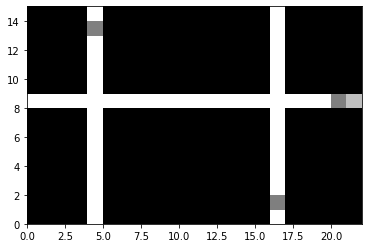

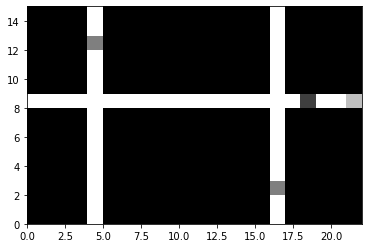

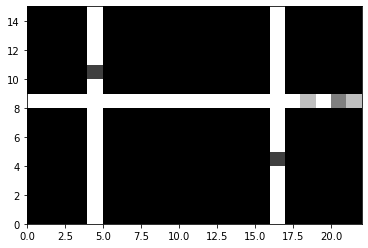

In [956]:
sim_sample = SF_Traffic_Sim() 
n_sims = 3 
for i in range(n_sims):
    sim_sample.update()
    sim_sample.draw()

## Model Simulations and Analysis 

### Original Results 

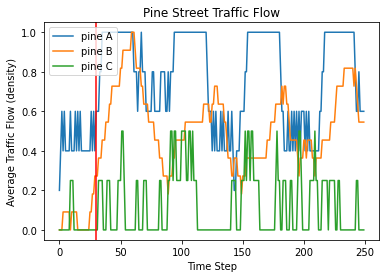

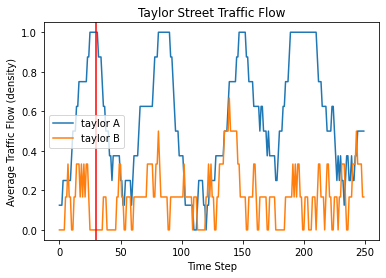

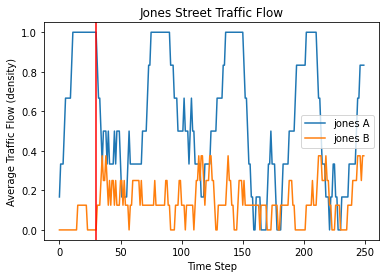

In [868]:
sim = SF_Traffic_Sim()
n_sims = 250
interval = 30
for i in range(n_sims):
    sim.update()
#     if i % 50 == 0:
#         sim.draw()
    
    if i % interval == 0:
        sim.TL_change_A()
        sim.TL_change_B()
        
# plt.figure(figsize = (15,10))
plt.plot(list(range(n_sims)),sim.pineA.lane_densities, label = 'pine A')
plt.plot(list(range(n_sims)),sim.pineB.lane_densities, label = 'pine B')
plt.plot(list(range(n_sims)),sim.pineC.lane_densities, label = 'pine C')
plt.axvline(interval, c = 'r')
plt.title("Pine Street Traffic Flow")
plt.xlabel("Time Step")
plt.ylabel("Average Traffic Flow (density)")

plt.legend()
plt.show()

# plt.figure(figsize = (15,10))
plt.plot(list(range(n_sims)),sim.taylorA.lane_densities, label = 'taylor A')
plt.plot(list(range(n_sims)),sim.taylorB.lane_densities, label = 'taylor B')
plt.axvline(interval, c = 'r')
plt.title("Taylor Street Traffic Flow")
plt.xlabel("Time Step")
plt.ylabel("Average Traffic Flow (density)")

plt.legend()
plt.show()

# plt.figure(figsize = (15,10))
plt.plot(list(range(n_sims)),sim.jonesA.lane_densities, label = 'jones A')
plt.plot(list(range(n_sims)),sim.jonesB.lane_densities, label = 'jones B')
plt.axvline(interval, c = 'r')
plt.title("Jones Street Traffic Flow")
plt.xlabel("Time Step")
plt.ylabel("Average Traffic Flow (density)")


plt.legend()
plt.show()


In [875]:
sim_waiting_times = []
for i in range(500):
    sim = SF_Traffic_Sim()
    n_sims = 250
    interval = 30
    for i in range(n_sims):
        sim.update()
    #     if i % 50 == 0:
    #         sim.draw()

        if i % interval == 0:
            sim.TL_change_A()
            sim.TL_change_B()

    avg_car_times = sim.taylorB.car_times + sim.jonesB.car_times + sim.pineC.car_times
    
    sim_waiting_times.append(np.mean(avg_car_times))


Mean: 27.64379405085303
Conf Int: [25.01276795 30.24615385]
Std dev: 1.5538664031805132


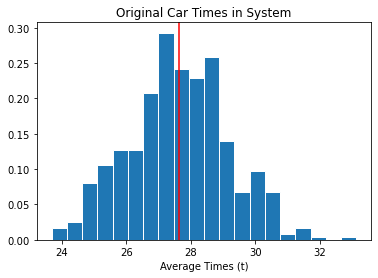

In [892]:
plt.hist(sim_waiting_times, density = True, bins = 20, edgecolor = 'w')
plt.xlabel("Average Times (t)")
plt.axvline(np.mean(sim_waiting_times), color = 'r')
plt.title("Original Car Times in System")
print("Mean:",np.mean(sim_waiting_times))
print("Conf Int:", np.quantile(sim_waiting_times, [0.05, 0.95]))
print("Std dev:", np.std(sim_waiting_times))

plt.show()

### Modified System (Changing Traffic Light Timings)

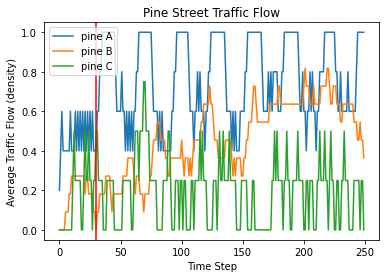

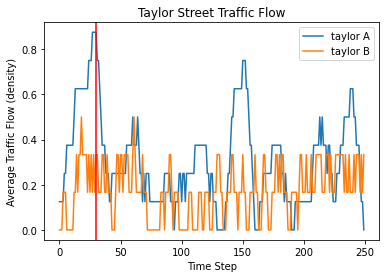

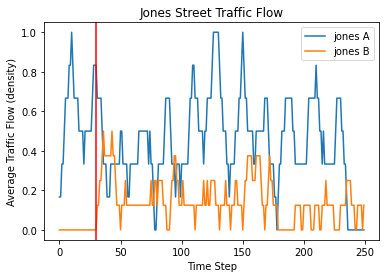

In [865]:
sim = SF_Traffic_Sim()
n_sims = 250
for i in range(n_sims):
    sim.update()
#     sim.draw()
    
    if i % 10 == 0:
        sim.TL_change_A()
       
    if sim.fourth_connection.TLisGreen == True:
        if i % 30 == 0:
            sim.TL_change_B()
    else:
        if i % 15 == 0:
            sim.TL_change_B()

# plt.figure(figsize = (15,10))
plt.plot(list(range(n_sims)),sim.pineA.lane_densities, label = 'pine A')
plt.plot(list(range(n_sims)),sim.pineB.lane_densities, label = 'pine B')
plt.plot(list(range(n_sims)),sim.pineC.lane_densities, label = 'pine C')
plt.axvline(interval, c = 'r')
plt.title("Pine Street Traffic Flow")
plt.xlabel("Time Step")
plt.ylabel("Average Traffic Flow (density)")

plt.legend()
plt.show()

# plt.figure(figsize = (15,10))
plt.plot(list(range(n_sims)),sim.taylorA.lane_densities, label = 'taylor A')
plt.plot(list(range(n_sims)),sim.taylorB.lane_densities, label = 'taylor B')
plt.axvline(interval, c = 'r')
plt.title("Taylor Street Traffic Flow")
plt.xlabel("Time Step")
plt.ylabel("Average Traffic Flow (density)")

plt.legend()
plt.show()

# plt.figure(figsize = (15,10))
plt.plot(list(range(n_sims)),sim.jonesA.lane_densities, label = 'jones A')
plt.plot(list(range(n_sims)),sim.jonesB.lane_densities, label = 'jones B')
plt.axvline(interval, c = 'r')
plt.title("Jones Street Traffic Flow")
plt.xlabel("Time Step")
plt.ylabel("Average Traffic Flow (density)")


plt.legend()
plt.show()


In [880]:
sim_waiting_times_2 = []

for i in range(500):
    sim = SF_Traffic_Sim()
    n_sims = 250
    for i in range(n_sims):
        sim.update()
    #     sim.draw()

        if i % 10 == 0:
            sim.TL_change_A()

        if sim.fourth_connection.TLisGreen == True:
            if i % 30 == 0:
                sim.TL_change_B()
        else:
            if i % 15 == 0:
                sim.TL_change_B()

    avg_car_times = sim.taylorB.car_times + sim.jonesB.car_times + sim.pineC.car_times
    
    sim_waiting_times_2.append(np.mean(avg_car_times))





Mean: 22.802336009560218
Conf Int: [20.27598945 25.3436313 ]
Std dev: 1.5461931091811436


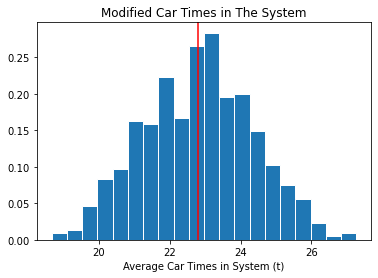

In [893]:
plt.hist(sim_waiting_times_2, density = True, bins = 20, edgecolor = 'w')
plt.title("Modified Car Times in The System")
plt.xlabel("Average Car Times in System (t)")

conf_int2 = np.quantile(sim_waiting_times_2, [0.05, 0.95])

plt.axvline(np.mean(sim_waiting_times_2), color = 'r')
print("Mean:",np.mean(sim_waiting_times_2))
print("Conf Int:", np.quantile(sim_waiting_times_2, [0.05, 0.95]))
print("Std dev:", np.std(sim_waiting_times_2))
plt.show()

### Theoretical Analysis 

Estimating the amount of cars waiting in the lane before the traffic light changes. In this analysis, we will be focusing on Jones St. A since this is an inflow street and connects to an intersection. 

In our original model, the traffic light changes every 30 time steps. Therefore, we can have a formula in estimating the density of the street before a traffic light becomes "Green".

$$\frac{p(\text{car spawning}) \cdot \text{Time before Traffic Light changes}} {\text{Road Length}}=\text{Average Road Density Before Traffic Light Changes}$$



In [909]:
# Theoretical Analysis on Taylor St. A 
# self.taylorA = Lane(road_length = 8, max_speed = 3, car_spawn_prob = 0.25,
#                    prob_slow = 0.2, gen_car = True, end_road = False)

TL_interval = 30 
road_length = 8
x = np.linspace(0.05, 0.25, 10)
theoretical = []

for i in x:
    avg_cars = i * TL_interval
    theoretical.append(avg_cars/road_length)
    
empirical = [] 

for point in x: 
    sim_avg_density = []
    for i in range(1000):
        taylorA = Lane(road_length = road_length, max_speed = 3, car_spawn_prob = point,
              prob_slow = 0.2, gen_car = True, end_road = False)
        
        sim_avg_density.append(taylorA.lane_densities)
        
        # Change traffic light 
        for i in range(300):
            taylorA.update()
            
            if i % 30 == 0:
                taylorA.end_road = not taylorA.end_road
    
    empirical.append(np.mean(sim_avg_density))
            

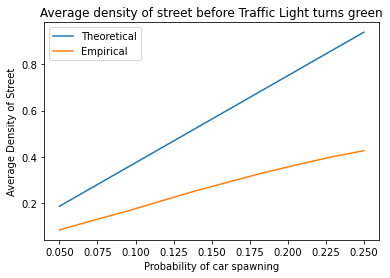

In [913]:
plt.title("Average density of street before Traffic Light turns green")
plt.plot(x, theoretical, label = 'Theoretical')
plt.plot(x, empirical, label = 'Empirical')
plt.xlabel("Probability of car spawning")
plt.ylabel("Average Density of Street")
plt.legend()
plt.show()

In [924]:
sim_avg_density = []
for i in range(1000):
    taylorA = Lane(road_length = road_length, max_speed = 3, car_spawn_prob = 0.25,
          prob_slow = 0.2, gen_car = True, end_road = False)

    for i in range(300):
        taylorA.update()

        # Change traffic light 
        if i % 30 == 0:
            taylorA.end_road = not taylorA.end_road
            
    sim_avg_density.append(np.mean(taylorA.lane_densities))

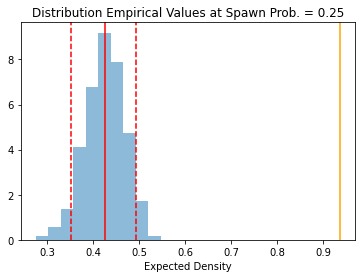

Mean: 0.4259616666666667
Conf Int [0.3533125  0.49422917]
Std. dev: 0.043144196886719305


In [953]:
theoretical_point = (0.25 * 30)/road_length

plt.hist(sim_avg_density, alpha = 0.5, density = True)
plt.axvline(theoretical_point, c  = 'orange', label = 'expected mean')
plt.axvline(np.mean(sim_avg_density), c = 'r', label = 'mean')
conf_int = np.quantile(sim_avg_density, [0.05, 0.95])
plt.axvline(conf_int[0], linestyle = '--', c = 'r', label = '95% Confidence Interval')
plt.axvline(conf_int[1], linestyle = '--', c = 'r')
plt.title("Distribution Empirical Values at Spawn Prob. = 0.25")
plt.xlabel("Expected Density")
plt.show()
print("Mean:", np.mean(sim_avg_density))
print("Conf Int", conf_int)
print("Std. dev:", np.std(sim_avg_density))